In [2]:
# Loads the package
! pip install -q 'gwosc==0.5.4'
! pip install pycbc
! pip install -q gwpy

/usr/local/lib/python3.10/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


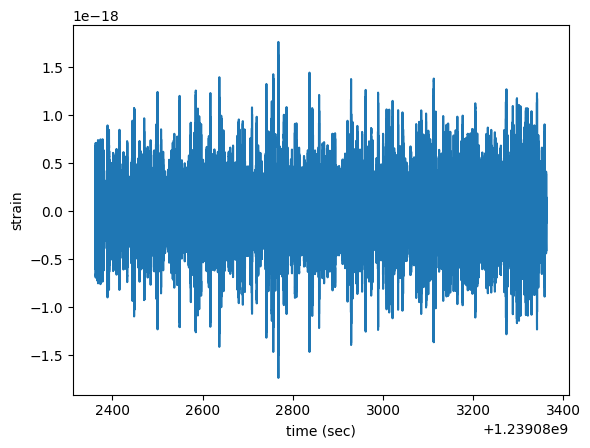

In [3]:
#this imports the required packages
import numpy as np
import pycbc
from pycbc.types import FrequencySeries, TimeSeries
import matplotlib.pyplot as plt
#this loads the data
d = np.load('noise_ts_4096Hz.npy')
time = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = time[1]-
time[0])
data = d
#this plots the data (time vs strain)
plt.plot(time, data)
plt.xlabel('time (sec)')
plt.ylabel('strain')
# this stops teh warnings so that the output looks nicer
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

(1e-47, 1e-42)

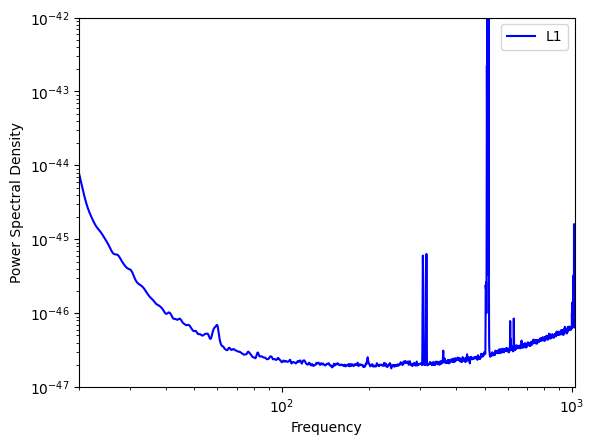

In [4]:
#this imports the functionalities required for calculating PSD
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
import pylab
#This plots the PSD vs frequency
fd = data.to_frequencyseries()
plt.plot(time, data, color='blue')
plt.xlabel('time (sec)')
plt.ylabel('strain')
#this uses the welch method with 2 second samples to calculate the psd of the data
psd = data.psd(2)
# we calculated PSD using welch method, but now we need to interpolate it
psd1 = interpolate(psd, fd.delta_f)
psd1 = inverse_spectrum_truncation(psd1, int(2*data.sample_rate), trunc_method='hann')
pylab.loglog(psd1.sample_frequencies, psd1, label='L1', color='blue')
pylab.xlabel("Frequency")
pylab.ylabel("Power Spectral Density")
pylab.legend()

pylab.xlim(20, 1024)
pylab.ylim(1e-47, 1e-42)

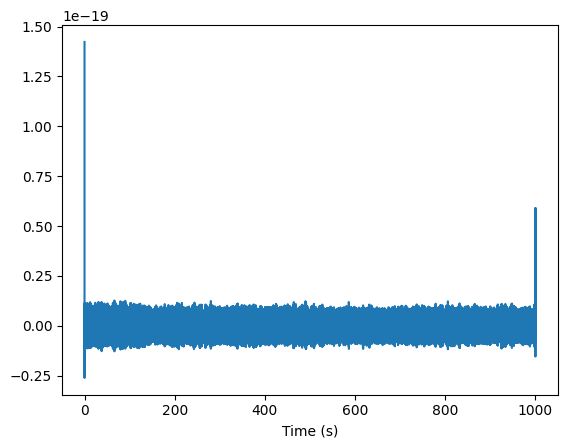

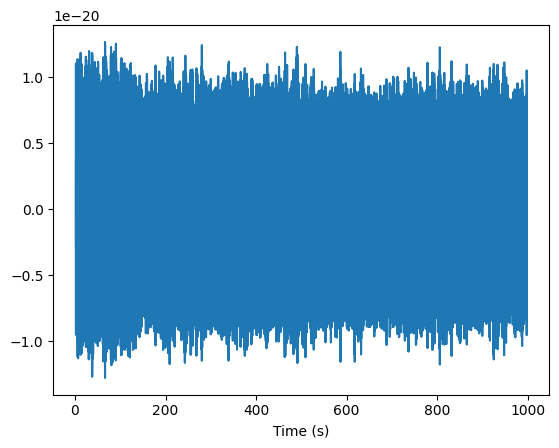

In [77]:
# defines data as strain; highpasses the data and cuts frequencies below 15 Hz
# in general, this step is about conditioning the data
data = strain
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

# crops the first and last two seconds of the data to avoid artifacts
conditioned = strain.crop(2, 2)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

# this uses the welch method with 4 second samples to calculate the PSD of the data
psd = conditioned.psd(4)

# we calculated PSD using welch method, but now we need to interpolate it
# and also limit the filter length to 1/PSD; after that we can finally use the PSD
# to filter the data in a controlled manner; also since the data has been high passed
# above 15 Hz, we need to inform the function to exclude the frequencies below that
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),low_frequency_cutoff=15)

In [78]:
# here we generate a waveform and set the f_lower to 15 Hz, which is our cutoff frequency
# The assumption was that he GW signals can produce only from equal mass binary systems
# with a range between 5 to 10; the mass of 9 was chosen as everything below kept spitting out
# an error
from pycbc.waveform import get_td_waveform

m = 9 #solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=15)

# this resizes  vector to match data
hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

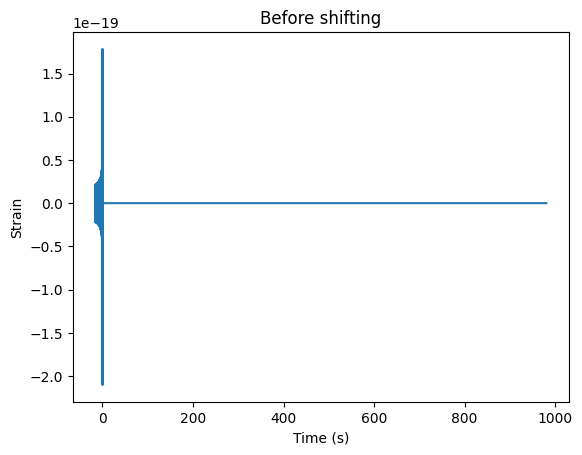

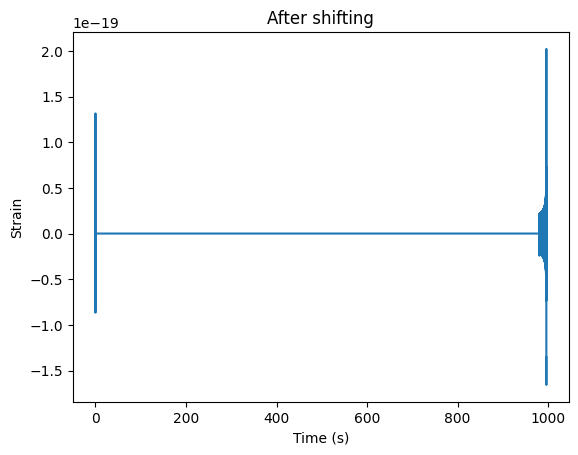

In [79]:
# here we plot the signal; we need to shift the data so that the merger is
# approximately at the first bin of the data
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

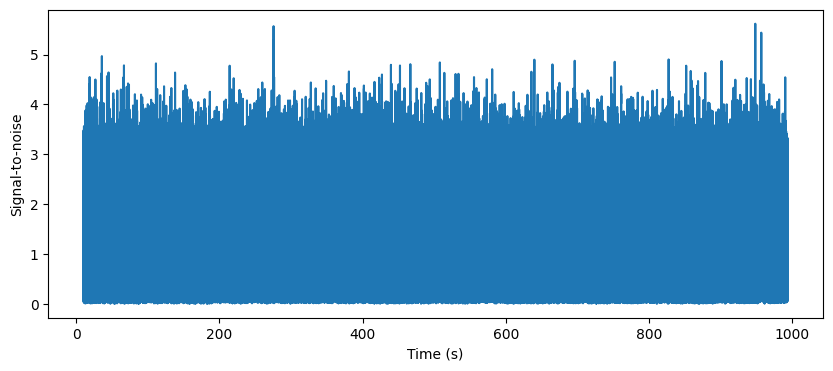

We found a signal at 948.4135742190002s with SNR 5.619631715557572


In [80]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=15)

# here we remove the time corruption by the template and psd filter
# by removing 4 seonds from the beginning and 4s seconds from end and
# 4 exrta seconds at the beginning in order to account for the template length
snr = snr.crop(4 + 4, 4)

# this plots
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))

In [1]:
# The signal was found to have an SNR of 5.619, but our assumption was that it needs to be at least 8
# to claim detection of GW, so it can be concluded that there was no GW there

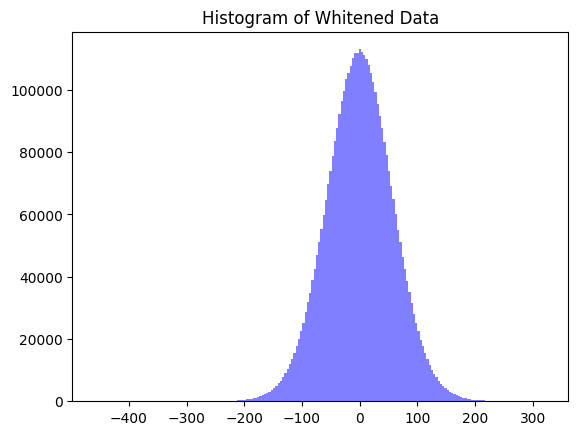

In [10]:
from pycbc.psd import welch, interpolate, inverse_spectrum_truncation
import pylab
# here again we calculate the psd of the data using the
# welch method with stepsize of 2 seconds (I decided to do it again as
# when when I was trying to call the previous PSDs I defined, I kept running
# into errors)
psd = data.psd(2)
# here, we interpolate from the PSD
psd1 = interpolate(data.psd(2), fd.delta_f)
psd1 = inverse_spectrum_truncation(psd1, int(2*data.sample_rate))
# whitening; converting the data to a frequency series is necessary
# for whitening, as it allows us to operate in the frequency domain. we divide each
# frequency component of the data by the corresponding frequency component of the PSD.
# we scale each frequency component by the square root of the PSD,
# as the PSD represents the square of the amplitude of each frequency component.
white_data = (data.to_frequencyseries() / psd1**0.5).to_timeseries()
white_data=white_data.crop(2,2)
# here we plot the whitened data on a histogram by dividing the data into 200 bins
unga = 200
n, bins, patches = plt.hist(white_data, unga, facecolor='blue', alpha=0.5)
plt.title("Histogram of Whitened Data")
plt.show()

In [11]:
import numpy as np

# Calculate the mean of the whitened data
mean_white_data = np.mean(white_data)

print("Mean of the whitened data:", mean_white_data)


Mean of the whitened data: 0.0009573690680948494


In [ ]:
# as it can be seen from the histogram, the whitened noise follows a Gaussian distribution (qualitatively)
# and also has mean of approximately zero

In [95]:
# now we want to show that the data is not stationary. considering that stationarity
# is a property of a time series that has a constant mean, variance and autocorrelation
# over time, we can divide our data into chunks and show that those are not constant

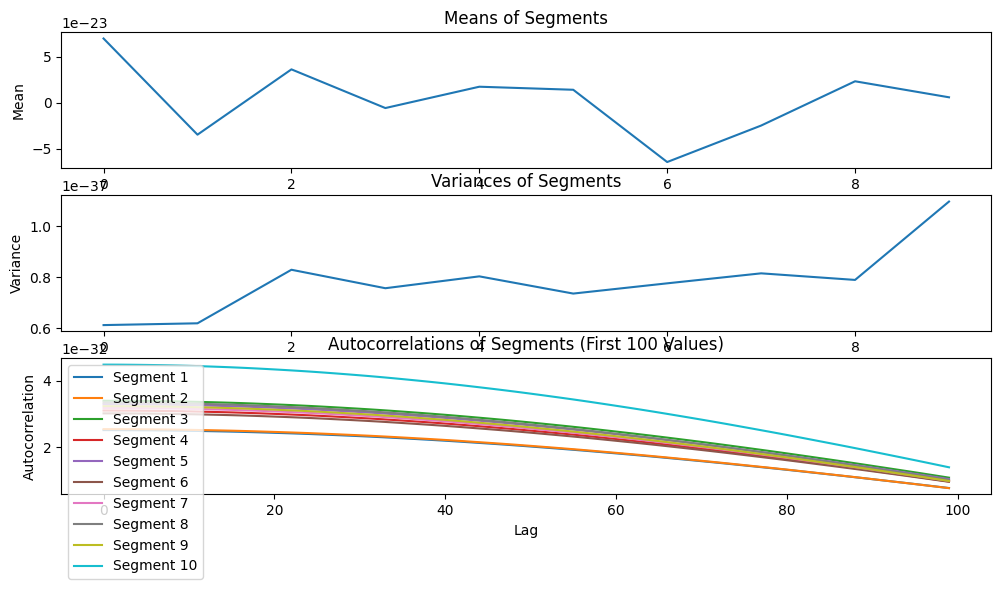

<Figure size 640x480 with 0 Axes>

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# here we define the parameters for our analysis. we know that the data is sampled at 4096 Hz
# for 1000 seconds. I choose to divide the data into 10 segments and then show the statistical
# differences between each segment on a plot
sampling_rate = 4096  # Hz
duration = 1000  # seconds
num_segments = 10  # Number of segments

# here we calculate the total number of samples
total_samples = sampling_rate * duration

# here we calculate the segment length
segment_length = total_samples // num_segments

# here we divide data into segments
segments = np.array_split(data, num_segments)

# we calculate mean, variance and autocorrelation for each segment
# (at first I used the "np.correlate" to calculate the autocorrelations,
# but the code was very slow so instead I used the FFT approach)
means = [np.mean(segment) for segment in segments]
variances = [np.var(segment) for segment in segments]
autocorrelations = [np.fft.ifft(np.abs(np.fft.fft(segment)) ** 2).real for segment in segments]


# here we compare statistics between the segments
mean_variation = np.std(means)
variance_variation = np.std(variances)
autocorrelation_variation = np.std(autocorrelations)

# and now we plot the three statistical measures
plt.figure(figsize=(12, 6))

# Plot means
plt.subplot(3, 1, 1)
plt.plot(means)
plt.title("Means of Segments")
plt.xlabel("Segment Index")
plt.ylabel("Mean")

# Plot variances
plt.subplot(3, 1, 2)
plt.plot(variances)
plt.title("Variances of Segments")
plt.xlabel("Segment Index")
plt.ylabel("Variance")

# Plot autocorrelations. Again I had to midify the code because it ran very long.
# Here I decided to loop through each segment and plot only the first 100 values of autocorrelation
plt.subplot(3, 1, 3)
for i in range(len(autocorrelations)):
    plt.plot(autocorrelations[i][:100], label=f'Segment {i+1}')  # Plot first 100 values for each segment

plt.title("Autocorrelations of Segments (First 100 Values)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.show()

plt.tight_layout()
plt.show()


In [ ]:
# as it can be seen, the mean, variance and autocorrelation vary across the segments
# of the data, which means that the noise is not stationary